In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import seaborn as sns
from tqdm import tqdm
import datetime
import calendar
from collections import defaultdict


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2


def month_str(time):
    '''
    Returns two strings representing the first and last day of time's month
    '''
    if time.month < 10:
        month_str = "0" + str(time.month)
    else:
        month_str = str(time.month)

    start_str = str(time.year) + "-" + month_str + "-01 00:14:00"
    last_day = calendar.monthrange(time.year, time.month)[1]
    end_str = str(time.year) + "-" + month_str + "-" + str(last_day) + " 23:59:00"
    return start_str, end_str


def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time



class Normalised_Flow_Model:
    def __init__(self, train_report):
        self.time_range = pd.date_range("2019-03-19 00:14:00", "2022-04-08 23:59:00", freq="15min")
        # Don't include out of sync time values
        train_report_in_range = train_report[train_report.timestamp.isin(self.time_range)]
        self.predictions = train_report_in_range.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index()
        self.true_mu = self.predictions.total_volume_normalised.sum() / len(self.time_range)
        self.empty_times = []
        
    def check_empties(self):
        for t in tqdm(self.time_range):
            if len( self.predictions[self.predictions.timestamp==t] ) <1:
                self.empty_times.append(t)
                
        print(f"{len(self.empty_times)} of {len(self.time_range)} time values are empty, {len(self.empty_times)/len(self.time_range) *100} %")
        
    def N(self,t):
        result = self.predictions[self.predictions.timestamp == t]
        if len(result) == 1:
            N_t = result.total_volume_normalised.to_numpy().item()
        else:
            N_t = 0
        return N_t
    
    
    def mean_N(self, date_range):
        '''
        Returns the average normalised volume over date_range
        '''
        N_t_in_date_range = self.predictions[self.predictions.timestamp.isin(date_range)]
        mean_N_t = N_t_in_date_range.total_volume_normalised.sum()/len(date_range)
        return mean_N_t
    
    def mean_N_year(self, time):
        '''
        Returns a prediction for the average normalised volume over a year
        '''
        # Get two strings representing the start and end of the year
        start_time, end_time = year_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t
        
        
    def mean_N_month(self, time):
        '''
        Returns a prediction for the average normalised volume over a month
        '''
        # Get two strings representing the start and end of the month
        start_time, end_time = month_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t

In [2]:
def get_reports(test_loc):
    test_report = pd.concat([v for k,v in reports.items() if k == test_loc])
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report, test_report

In [3]:
def model_window(train_report, test_report, time, date_range):
    avg_flow_preds = []
    avg_flows = []
    model = Normalised_Flow_Model(train_report)
    
    # For each site in the test area estimate the average flow over date_range
    coverage = defaultdict(str)
    for site in tqdm(test_report[test_report.timestamp == time].site_id.unique()):
        # Obtain the ground truth average flow
        test_report_site = test_report[(test_report.site_id == site) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean() # group by time_peroid_ending so that all days are weighted equally
        
        # Give us the fraction of times in date range that the site actually reports
        coverage[site] = len(test_report_site)/len(date_range)
        
        # Calculate a prediction of average flow
        X_t = test_report_site[test_report_site.timestamp == time].total_volume.to_numpy()
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())


    metrics = report_metrics(avg_flows, avg_flow_preds)
    return metrics, model, coverage, avg_flows, avg_flow_preds

### Import Reports

In [4]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/yolov5--Separate-Directions-LiveSpeed-RecallAdjusted')

# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_bristol_report_df_norm')

# Import the reports that have the yearly data for all the sites
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')
image_year_report_manchester = pd.read_feather('image_year_traffic_reports/clean_manc_report_df')
image_year_report_cambridge = pd.read_feather('image_year_traffic_reports/clean_cam_report_df')
image_year_report_thorpe = pd.read_feather('image_year_traffic_reports/clean_thorpe_report_df')
image_year_report_epping = pd.read_feather('image_year_traffic_reports/clean_epping_report_df')
image_year_report_bristol = pd.read_feather('image_year_traffic_reports/clean_bristol_df')

# Put the Dataframe into dicts so that they can be eaility accessed
image_year_reports = {"birmingham": image_year_report_birmingham,
          "manchester" : image_year_report_manchester,
          "cambridge" : image_year_report_cambridge,
          "thorpe" : image_year_report_thorpe,
          "epping" : image_year_report_epping,
          "bristol" : image_year_report_bristol }

reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }


times = {"birmingham": datetime.datetime(2021,6,15,11,14),
          "manchester" : datetime.datetime(2019,4,19,12,59),
          "cambridge" : datetime.datetime(2021,11,2,11,29),
          "thorpe" : datetime.datetime(2022,3,8,11,14),
          "epping" : datetime.datetime(2022,3,8,11,14),
          "bristol" : datetime.datetime(2020,8,8,11,14) }

### AADT

In [5]:
AADT_results = defaultdict(str)
# Iterate through all the sites where we can calculate AADT
for area in ["birmingham", "cambridge", "bristol"]:
    print(area)
    train_report, test_report = get_reports(area)
    time = times[area]
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics, model, coverage, avg_flows, avg_flow_preds
    AADT_results[area] = model_window(train_report, test_report, time, date_range)

birmingham


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


cambridge


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 28.18it/s]


bristol


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.18it/s]


birmingham:
MSE:  4179.341678656952
MAE:  42.9748696432071
MAPE: 0.16389638974517995
R^2:  0.8842166245375844


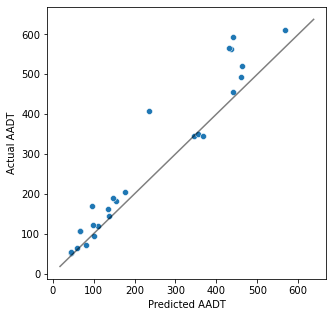

cambridge:
MSE:  352.71567957075666
MAE:  13.31104947782947
MAPE: 0.09358078327110023
R^2:  0.963740614437875


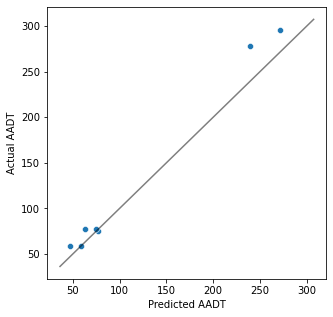

bristol:
MSE:  7712.858303307003
MAE:  82.82533264337847
MAPE: 0.42002152185478003
R^2:  -0.28009122961137045


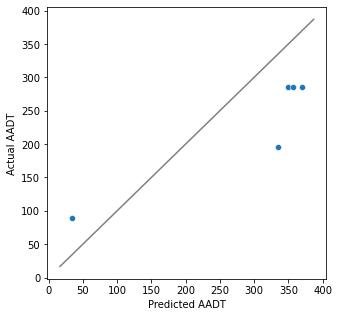

In [6]:
def plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT'):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(x=avg_flow_preds, y=avg_flows, ax=ax)
    # lims of the y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)
    plt.xlabel(f'Predicted {name}')
    plt.ylabel(f'Actual {name}')
    plt.show()

# Print and plot results
for location, AADT_result in AADT_results.items():
    print(f"{location}:")
    avg_flows, avg_flow_preds = AADT_result[-2:]
    metrics = AADT_result[0]
    mse, mae, mape, r2 = metrics
    print(f"MSE:  {mse}")
    print(f"MAE:  {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2:  {r2}")
    
    plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT')

### ADMT

In [7]:
AMDT_results = defaultdict(str)
for area in ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']:
    print(area)
    train_report, test_report = get_reports(area)
    time = times[area]
    start_str, end_str = month_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics, model, coverage, avg_flows, avg_flow_preds
    AMDT_results[area] = model_window(train_report, test_report, time, date_range)

birmingham


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  7.55it/s]


manchester


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.78it/s]


cambridge


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 25.99it/s]


thorpe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.42it/s]


epping


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.82it/s]


bristol


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.03it/s]


birmingham:
MSE:  5235.924630098997
MAE:  50.14475415084503
MAPE: 0.16487331312815945
R^2:  0.8858159380063912


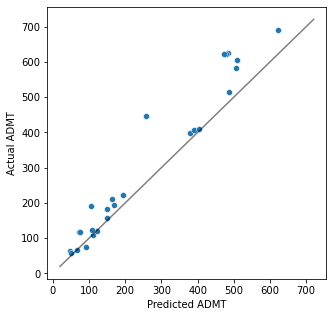

manchester:
MSE:  3306.3017449633626
MAE:  47.17158539125395
MAPE: 0.11897767464106097
R^2:  0.928944833438148


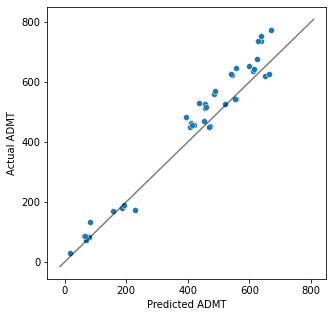

cambridge:
MSE:  624.2571814352335
MAE:  17.194421746674127
MAPE: 0.1070268351014522
R^2:  0.9494011981782094


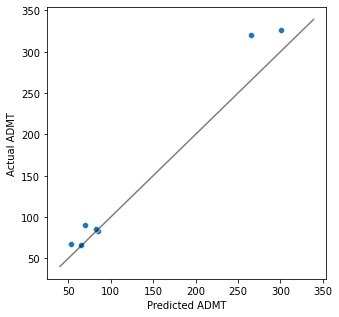

thorpe:
MSE:  1170.8440833055213
MAE:  29.34038646809215
MAPE: 0.06758502947740924
R^2:  0.9901734382360202


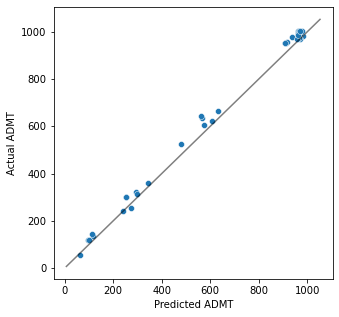

epping:
MSE:  669.0127446420399
MAE:  21.498986303254007
MAPE: 0.07339502153990901
R^2:  0.985764460278051


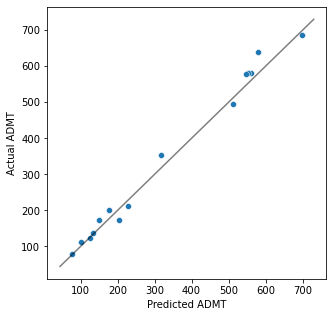

bristol:
MSE:  3972.109179191558
MAE:  57.47037516923272
MAPE: 0.257089241320655
R^2:  0.6771205907715474


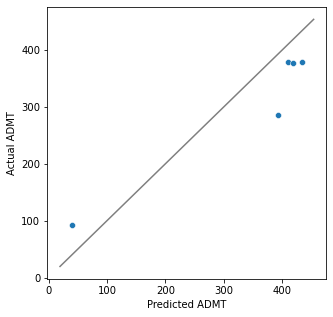

In [8]:
# Print and plot results

for location, AMDT_result in AMDT_results.items():
    print(f"{location}:")
    avg_flows, avg_flow_preds = AMDT_result[-2:]
    metrics = AMDT_result[0]
    mse, mae, mape, r2 = metrics
    print(f"MSE:  {mse}")
    print(f"MAE:  {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2:  {r2}")
    plot_actual_v_pred(avg_flows, avg_flow_preds, name='ADMT')

### AADT with satalite images

In [9]:
def model_window_satellite(train_report, test_report, time, date_range, traffic_predictions_focus):
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []
    model = Normalised_Flow_Model(train_report)
    
    # For each site in the test area estimate the average flow over date_range
    coverage = defaultdict(str)
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        # Obtain the count values via satellite for site_list
        X_t_sat = traffic_predictions_focus[traffic_predictions_focus.sites == sites_str].all_vehicle_pred.to_numpy()
        # Make a prediction of avg_flow from the satellites counts
        avg_flow_pred_sat = X_t_sat/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())
        avg_flow_preds_sat.append(avg_flow_pred_sat.item())
        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    return metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds, avg_flow_preds_sat

In [10]:
AADT_sat_results = defaultdict(str)
for area in ["birmingham", "cambridge", "bristol"]:
    print(area)
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    test_report = image_year_reports[area]
    time = times[area]
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AADT_sat_results[area] = model_window_satellite(train_report, test_report, time, date_range, traffic_predictions_focus)

birmingham
cambridge
bristol


Area birmingham
Satellite Metrics 		 Gold count metrics
MSE:  9725.016287189826 	 MSE: 8801.155820205877
MAE:  87.18043825708651  	 MAE: 75.48409186290844
MAPE: 0.36209432403474473 	 MAPE: 0.19534631093218544
R^2:  0.7963657485138349 	 R^2: 0.8157106656961071


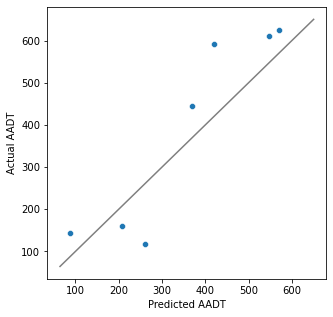

Area cambridge
Satellite Metrics 		 Gold count metrics
MSE:  14337.61482560224 	 MSE: 1578.2000840254775
MAE:  100.86493512987109  	 MAE: 31.04951838203279
MAPE: 0.2883099184991871 	 MAPE: 0.08786177138694458
R^2:  -2.7318594313932554 	 R^2: 0.5892189224054764


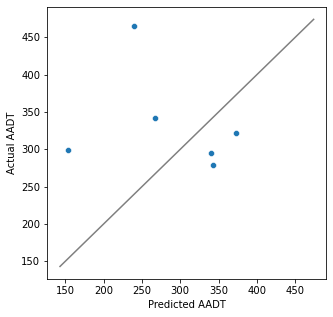

Area bristol
Satellite Metrics 		 Gold count metrics
MSE:  25107.225354649643 	 MSE: 7780.991346848005
MAE:  136.53608481481675  	 MAE: 78.24444168416758
MAPE: 0.3614994442699537 	 MAPE: 0.19216696121944357
R^2:  -4.1148250988709165 	 R^2: -0.5851377152507724


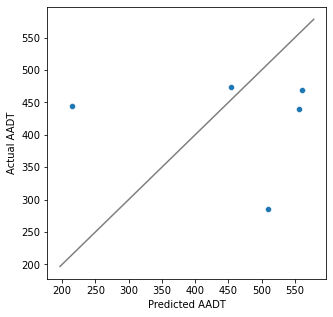

In [11]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result[-3:]
    metrics_gold_counts = AADT_result[0]
    metrics_satellite_counts = AADT_result[1]
    mse, mae, mape, r2 = metrics_satellite_counts
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    print('Satellite Metrics \t\t Gold count metrics')
    print(f"MSE:  {mse} \t MSE: {mse_g}")
    print(f"MAE:  {mae}  \t MAE: {mae_g}")
    print(f"MAPE: {mape} \t MAPE: {mape_g}")
    print(f"R^2:  {r2} \t R^2: {r2_g}")
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

In [12]:
AAMT_sat_results = defaultdict(str)
for area in ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']:
    print(f"Site {area}\n")
    traffic_predictions_focus = traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    test_report = image_year_reports[area]
    time = times[area]
    start_str, end_str = month_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AAMT_sat_results[area] = model_window_satellite(train_report, test_report, time, date_range, traffic_predictions_focus)

Site birmingham

Site manchester

Site cambridge

Site thorpe

Site epping

Site bristol



Area birmingham
Satellite Metrics 		 Gold count metrics
MSE:  9727.222780028196 	 MSE: 7934.414134082407
MAE:  86.23953712725756  	 MAE: 74.84736315229752
MAPE: 0.3348239669352959 	 MAPE: 0.1819042920814587
R^2:  0.8204168318491044 	 R^2: 0.8535155141562787


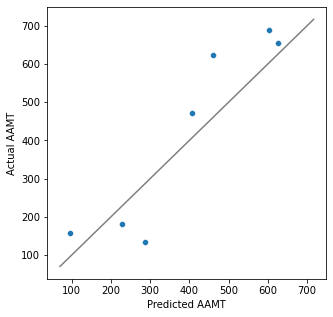

Area manchester
Satellite Metrics 		 Gold count metrics
MSE:  40077.94021233698 	 MSE: 9754.85488252449
MAE:  186.53710118632054  	 MAE: 82.7460388850151
MAPE: 0.3167579133293496 	 MAPE: 0.14580406987949235
R^2:  -0.7486390263723626 	 R^2: 0.5743863119260175


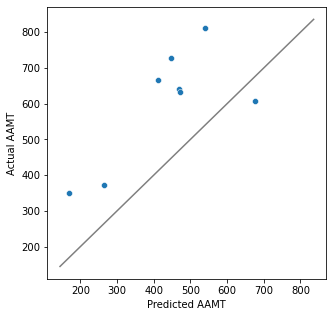

Area cambridge
Satellite Metrics 		 Gold count metrics
MSE:  14516.041898040276 	 MSE: 1192.5902765354265
MAE:  103.99036233004132  	 MAE: 31.065759552067146
MAPE: 0.2746053642457111 	 MAPE: 0.08589353135520428
R^2:  -4.707986193231014 	 R^2: 0.5310506210673873


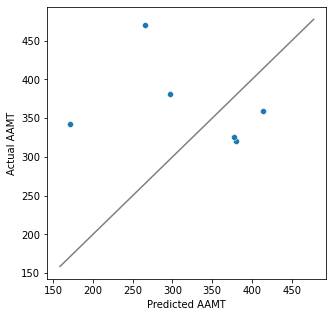

Area thorpe
Satellite Metrics 		 Gold count metrics
MSE:  1957.407334993456 	 MSE: 1764.365705936176
MAE:  32.914658479568686  	 MAE: 36.32140020079098
MAPE: 0.035317219928497616 	 MAPE: 0.046726769634052034
R^2:  0.918459358882533 	 R^2: 0.9265009851267423


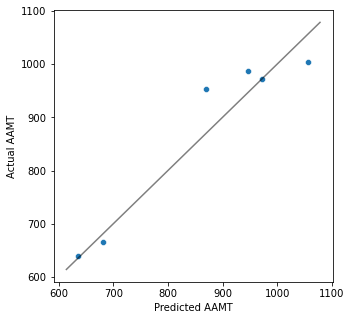

Area epping
Satellite Metrics 		 Gold count metrics
MSE:  32869.73726034813 	 MSE: 1796.3269735841932
MAE:  140.6809595572409  	 MAE: 34.7215865410433
MAPE: 0.2033112546933481 	 MAPE: 0.052675831926650554
R^2:  -1.6820723624511338 	 R^2: 0.8534250854634113


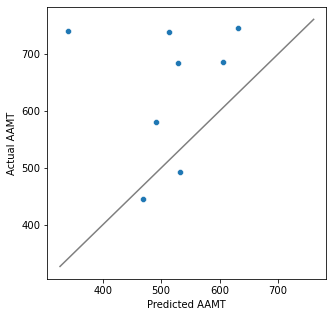

Area bristol
Satellite Metrics 		 Gold count metrics
MSE:  37995.45425265741 	 MSE: 4503.582381387827
MAE:  152.59693145812622  	 MAE: 55.33605713245371
MAPE: 0.2956206680089076 	 MAPE: 0.10073555227887236
R^2:  -3.7273602841037237 	 R^2: 0.43966832599525896


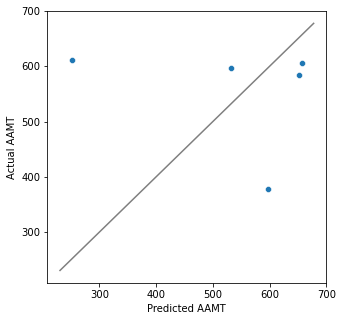

In [13]:
# Print and plot results

for location, AAMT_result in AAMT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AAMT_result[-3:]
    metrics_gold_counts = AAMT_result[0]
    metrics_satellite_counts = AAMT_result[1]
    mse, mae, mape, r2 = metrics_satellite_counts
    mse, mae, mape, r2 = metrics_satellite_counts
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    print('Satellite Metrics \t\t Gold count metrics')
    print(f"MSE:  {mse} \t MSE: {mse_g}")
    print(f"MAE:  {mae}  \t MAE: {mae_g}")
    print(f"MAPE: {mape} \t MAPE: {mape_g}")
    print(f"R^2:  {r2} \t R^2: {r2_g}")
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AAMT')